In [189]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn, Tensor

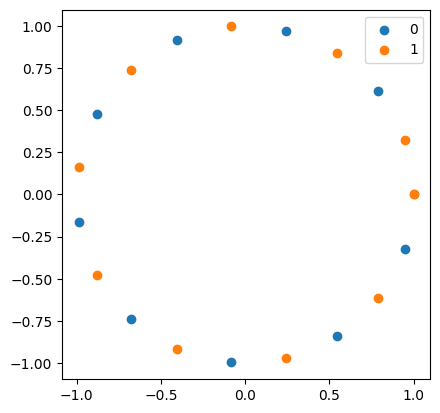

In [190]:
angles = 2 * np.linspace(0, 1, 20) * np.pi

x, y = np.cos(angles), np.sin(angles)
clazz = np.sin(10 * angles) > 0
plt.scatter(x[clazz], y[clazz], label='0')
plt.scatter(x[~clazz], y[~clazz], label='1')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [214]:
classifier = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)
optim = torch.optim.AdamW(classifier.parameters(), lr=1e-3)

In [215]:
for p in classifier.parameters():
    print(p.shape)

torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [192]:
x = torch.from_numpy(
    np.stack([x, y], axis=-1)
).to(torch.float32)
y = torch.from_numpy(clazz).to(torch.float32).reshape(-1, 1)

In [194]:
from tqdm import trange

bar = trange(5_000)
for _ in bar:
    optim.zero_grad()
    preds = classifier(x)
    loss = F.binary_cross_entropy_with_logits(preds, y)
    loss.backward()
    optim.step()
    bar.set_description(str(float(loss.item())))

4.729747161036357e-05: 100%|██████████| 5000/5000 [00:15<00:00, 317.39it/s] 


In [195]:
with torch.no_grad():
    accuracy = (classifier(x) > 0) == (y > 0.5)
    print(accuracy.sum() / len(accuracy))

tensor(1.)


In [196]:
for p in classifier.parameters():
    p.requires_grad = True

In [197]:
from torch.autograd import grad

zerograd_points = []

points = torch.randn(100, 2, dtype=torch.float32, requires_grad=True)
labels = torch.zeros((100, 1), dtype=torch.float32)
labels[50:] = 1

zerograd_points.append(points.detach())

opt = torch.optim.Adam([points], lr=0.1)

bar = trange(10_000)

for _ in bar:
    opt.zero_grad()
    classifier.zero_grad()
    preds = classifier(points)
    l = F.binary_cross_entropy_with_logits(preds, labels)
    g = grad(l.sum(), classifier.parameters(), create_graph=True)
    loss = sum(torch.mean(p ** 2) for p in g)
    loss.backward()
    opt.step()
    zerograd_points.append(points.detach())

    accuracy = (preds > 0.5) == (labels > 0.5)
    accuracy = accuracy.sum() / len(accuracy)
    bar.set_description(f'{accuracy}% {float(loss)}')

1.0% 1.2374222757571829e-09: 100%|██████████| 10000/10000 [00:47<00:00, 210.98it/s]              


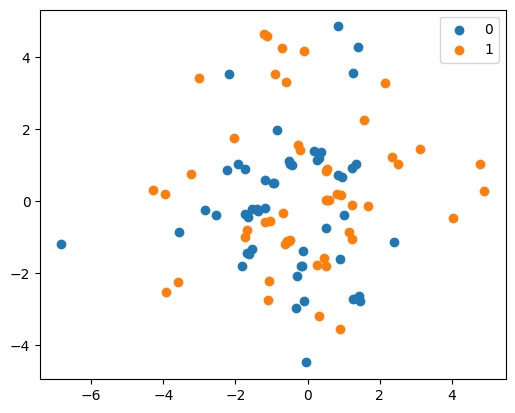

In [198]:
x_, y_ = zerograd_points[-1].numpy()[..., 0], zerograd_points[-1].numpy()[..., 1]
c = labels.detach().numpy().reshape(-1) > 0.5
plt.scatter(x_[c], y_[c], label='0')
plt.scatter(x_[~c], y_[~c], label='1')
plt.gca().set_aspect('equal')
plt.legend()

In [208]:
from torch.autograd import grad

directional_points = []

with torch.no_grad():
    directions = [
        p / torch.abs(p ** 2).sum()
        for p in classifier.parameters()
    ]

n = 100
points = torch.randn(n, 2, dtype=torch.float32, requires_grad=True)
labels = torch.zeros((n, 1), dtype=torch.float32)
with torch.no_grad():
    labels[n // 2:] = 1

directional_points.append(points.detach().clone())

opt = torch.optim.SGD([points], lr=0.01)

bar = trange(5_000)

for _ in bar:
    opt.zero_grad()
    classifier.zero_grad()
    preds = classifier(points)
    l = F.binary_cross_entropy_with_logits(preds, labels)
    g = grad(l.sum(), classifier.parameters(), create_graph=True, retain_graph=True)
    loss = sum(torch.abs(p / torch.abs(p ** 2).sum() + d).mean() for p, d in zip(g, directions))
    loss.backward()
    opt.step()
    directional_points.append(points.clone().detach())

    accuracy = (preds > 0) == (labels > 0.5)
    accuracy = accuracy.sum() / len(accuracy)
    bar.set_description(f'{accuracy}%, {float(loss.detach())}')

0.44999998807907104%, 0.023345565423369408: 100%|██████████| 5000/5000 [00:28<00:00, 173.62it/s]


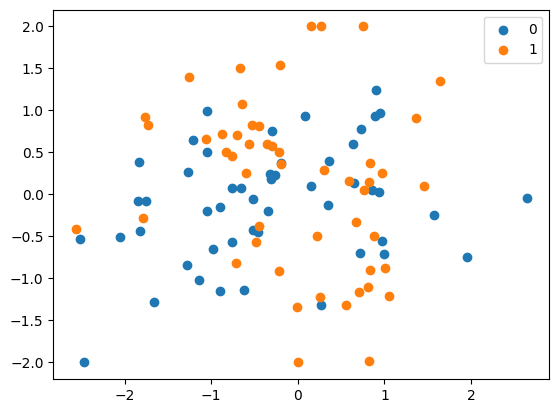

In [213]:
x_, y_ = directional_points[-1].numpy()[..., 0].clip(-5, 5), directional_points[-1].numpy()[..., 1].clip(-2, 2)
c = labels.detach().numpy().reshape(-1) > 0.5
plt.scatter(x_[c], y_[c], label='0')
plt.scatter(x_[~c], y_[~c], label='1')
plt.legend()